# 패키지 다운로드

In [ ]:
# pip install xarray

# 패키지 로딩

In [42]:
import xarray as xr

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

import warnings

warnings.filterwarnings("ignore")

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 종속변수(SCTR) 전처리

In [ ]:
# nc -> csv 변환
ds = xr.open_dataset('./data/EN.4.2.2_D20_SCTR_f.nc')

df = ds.D20_SCTR.to_dataframe()

df.reset_index(inplace=True)

df.to_csv('./output/SCTR.csv', index=False)

ds.close()

# 종속변수 불러오기

In [3]:
sctr = pd.read_csv("./output/SCTR.csv")

# 날짜 형식 통일
sctr["TIME1"] = pd.to_datetime(sctr["TIME1"])
sctr["TIME1"] = sctr["TIME1"].dt.to_period('M').dt.to_timestamp()

# 날짜 컬럼 이름 변경
sctr = sctr.rename(columns={"TIME1":"Date"})

sctr

,Date,D20_SCTR
0,1991-01-01,54.960640
1,1991-02-01,59.899442
2,1991-03-01,70.225124
3,1991-04-01,67.375125
4,1991-05-01,63.783066
...,...,...
395,2023-12-01,124.376897
396,2024-01-01,117.300079
397,2024-02-01,121.968669
398,2024-03-01,118.355688


# 독립변수 전처리

## IOD
- WTIO  : 동경 50도 ~ 70도, 남위 10도 ~ 북위 10도에서 SST 편차의 평균 
- SETIO : 동경 90도 ~ 110도, 남위 10도 ~ 적도선에서 SST 편차의 평균
- DMI  = WTIO - SETIO

In [ ]:
# txt -> csv 변환
IOD = pd.read_csv("./data/IOD.txt", sep="\t", encoding="cp949")

# 날짜 형식 통일
IOD['Date'] = pd.to_datetime(IOD['Year'].astype(str) + '-' + IOD['Month'].astype(str) + '-01')
IOD = IOD.drop(["Year", "Month"], axis = 1)
IOD = IOD[["Date", "WTIO", "SETIO"]]

# DMI(Dipole Mode Index) 컬럼 생성
IOD["DMI"] = IOD["WTIO"] - IOD["SETIO"]

IOD.to_csv("./output/IOD.csv", encoding="utf-8-sig", index=False)

In [ ]:
IOD = pd.read_csv("./output/IOD.csv")

IOD

## ONI

In [ ]:
# txt -> csv 변환
ONI = pd.read_csv("./data/ONI.txt", sep="\t", encoding="cp949")

# 날짜 형식 통일
ONI['Date'] = pd.to_datetime(ONI['Date'].astype(str) + '-01')

ONI.to_csv("./output/ONI.csv", encoding="utf-8-sig", index=False)

In [ ]:
ONI = pd.read_csv("./output/ONI.csv")

ONI

## OISST
- NINO 3.4(북위 5도 ~ 남위 5도, 서경 170도 ~ 120도)의 평균 해수면 온도 & 편차

In [ ]:
# txt -> csv 변환
OISST = pd.read_csv("./data/OISST.txt", sep="\t", encoding="cp949")

OISST['Date'] = pd.to_datetime(OISST['Date'])

OISST.to_csv("./output/OISST.csv", encoding="utf-8-sig", index=False)

In [ ]:
OISST = pd.read_csv("./output/OISST.csv")

OISST

## SOI
- 남방진동지수, Darwin - Tahiti 사이의 표준화된 해면기압 차이

In [ ]:
# txt -> csv 변환
SOI = pd.read_csv("./data/SOI.txt", sep="\t", encoding="cp949")

# 날짜 형식 통일
SOI['Date'] = pd.to_datetime(SOI['Date'].astype(str) + '-01')

SOI.to_csv("./output/SOI.csv", encoding="utf-8-sig", index=False)

In [ ]:
SOI = pd.read_csv("./output/SOI.csv")

SOI

## 독립변수 합치기

In [ ]:
df = pd.merge(IOD, ONI, on="Date")
df = pd.merge(df, OISST, on="Date")
df = pd.merge(df, SOI, on="Date")

df.to_csv("./output/IND.csv", encoding="utf-8-sig", index=False)

# 독립변수 불러오기 & 종속변수 합치기

In [5]:
ind = pd.read_csv("./output/IND.csv")

ind["Date"] = pd.to_datetime(ind["Date"])

data = pd.merge(ind, sctr, on="Date").drop("Date", axis = 1)

data.to_csv("./output/data.csv", encoding="cp949", index=False)

In [2]:
data = pd.read_csv("./output/data.csv")

data

,WTIO,SETIO,DMI,ONI,NINO3.4,ANOM,SOI,D20_SCTR
0,0.18,0.12,0.06,0.41,26.89,0.33,0.6,54.960640
1,0.05,-0.04,0.09,0.26,26.87,0.14,0.3,59.899442
2,-0.04,0.02,-0.06,0.22,27.16,-0.08,-0.7,70.225124
3,0.31,-0.45,0.76,0.26,27.89,0.08,-0.6,67.375125
4,0.28,-0.62,0.90,0.45,28.13,0.25,-1.0,63.783066
...,...,...,...,...,...,...,...,...
395,1.14,-0.07,1.21,1.95,28.64,1.99,-0.2,124.376897
396,1.18,0.36,0.82,1.79,28.34,1.78,0.5,117.300079
397,1.22,0.92,0.30,1.49,28.26,1.53,-1.4,121.968669
398,0.95,0.41,0.54,1.14,28.47,1.24,0.4,118.355688


# OISST 빼기(NINO3.4, ANOM)

In [3]:
data = data.drop(["NINO3.4", "ANOM"], axis = 1)

data

,WTIO,SETIO,DMI,ONI,SOI,D20_SCTR
0,0.18,0.12,0.06,0.41,0.6,54.960640
1,0.05,-0.04,0.09,0.26,0.3,59.899442
2,-0.04,0.02,-0.06,0.22,-0.7,70.225124
3,0.31,-0.45,0.76,0.26,-0.6,67.375125
4,0.28,-0.62,0.90,0.45,-1.0,63.783066
...,...,...,...,...,...,...
395,1.14,-0.07,1.21,1.95,-0.2,124.376897
396,1.18,0.36,0.82,1.79,0.5,117.300079
397,1.22,0.92,0.30,1.49,-1.4,121.968669
398,0.95,0.41,0.54,1.14,0.4,118.355688


# 중간정리
- IOD(WTIO, SETIO, DMI)는 WTIO, SETIO / DMI로 나눠서 모델 구성
- SOI는 이미 표준화되어 있으므로 표준화 O, X 나눠서 모델 구성

# 함수 정의

In [4]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size

    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i + target_size])
            
    return np.array(data), np.array(labels)

In [5]:
def plot_train_history(history, function):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))
    
    plt.rcParams['font.family'] ='Malgun Gothic'
    plt.figure(figsize=(12, 8))
    
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    
    plt.xlabel("Epoch")
    plt.ylabel(function)
    
    plt.title("모델 손실함수 시각화")
    plt.legend()
    plt.grid()

    plt.show()

# 하이퍼 파라매터 세팅

In [8]:
# 전체 데이터 길이
total_length = len(data)

# 학습(0.7) - 검증(0.2) - 테스트(0.1) 데이터 분리
TRAIN_SPLIT = int(total_length * 0.7)
VAL_SPLIT = int(total_length * 0.2)
TEST_SPLIT = total_length - TRAIN_SPLIT - VAL_SPLIT

# 12개월 학습 - 12개월 예측
past_history = 12
future_target = 12
STEP = 1

BATCH_SIZE = 16
EPOCHS = 300

tf.random.set_seed(13)

# Case1) WTIO, SETIO & SOI 표준화

## 데이터 전처리

In [9]:
case1_df = data[['WTIO', 'SETIO', 'ONI', 'SOI', 'D20_SCTR']]

case1_dts = case1_df.values

case1_mean = case1_dts.mean(axis=0)
case1_std = case1_dts.std(axis=0)
case1_dts = (case1_dts-case1_mean)/case1_std

In [10]:
case1_df

,WTIO,SETIO,ONI,SOI,D20_SCTR
0,0.18,0.12,0.41,0.6,54.960640
1,0.05,-0.04,0.26,0.3,59.899442
2,-0.04,0.02,0.22,-0.7,70.225124
3,0.31,-0.45,0.26,-0.6,67.375125
4,0.28,-0.62,0.45,-1.0,63.783066
...,...,...,...,...,...
395,1.14,-0.07,1.95,-0.2,124.376897
396,1.18,0.36,1.79,0.5,117.300079
397,1.22,0.92,1.49,-1.4,121.968669
398,0.95,0.41,1.14,0.4,118.355688


## 데이터 분리

In [11]:
# 학습 데이터
x_train_multi, y_train_multi = multivariate_data(case1_dts, case1_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# 검증 데이터
x_val_multi, y_val_multi = multivariate_data(case1_dts, case1_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# 테스트 데이터
x_test_multi, y_test_multi = multivariate_data(case1_dts, case1_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

print(f"학습 데이터 형태: {x_train_multi.shape}")
print(f"검증 데이터 형태: {x_val_multi.shape}")
print(f"테스트 데이터 형태: {x_test_multi.shape}")

print('과거 데이터 윈도우 형태: {}'.format(x_train_multi[0].shape))
print('예측 목표 기간 형태: {}'.format(y_train_multi[0].shape))

학습 데이터 형태: (256, 12, 5)
검증 데이터 형태: (56, 12, 5)
테스트 데이터 형태: (16, 12, 5)
과거 데이터 윈도우 형태: (12, 5)
예측 목표 기간 형태: (12,)


In [12]:
BUFFER_SIZE = 100

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))

train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

## 모델 학습

### 단방향 LSTM

Epoch 1/200
16/16 [==============================] - 5s 57ms/step - loss: 19.4580 - val_loss: 18.4794 - lr: 5.0000e-04
Epoch 2/200
16/16 [==============================] - 0s 12ms/step - loss: 18.4926 - val_loss: 17.8318 - lr: 5.0000e-04
Epoch 3/200
16/16 [==============================] - 0s 12ms/step - loss: 17.6924 - val_loss: 17.1499 - lr: 5.0000e-04
Epoch 4/200
16/16 [==============================] - 0s 12ms/step - loss: 16.9255 - val_loss: 16.4401 - lr: 5.0000e-04
Epoch 5/200
16/16 [==============================] - 0s 13ms/step - loss: 16.1174 - val_loss: 15.7163 - lr: 5.0000e-04
Epoch 6/200
16/16 [==============================] - 0s 12ms/step - loss: 15.3562 - val_loss: 14.9971 - lr: 5.0000e-04
Epoch 7/200
16/16 [==============================] - 0s 12ms/step - loss: 14.5915 - val_loss: 14.2847 - lr: 5.0000e-04
Epoch 8/200
16/16 [==============================] - 0s 12ms/step - loss: 13.8548 - val_loss: 13.5855 - lr: 5.0000e-04
Epoch 9/200
16/16 [=============================

16/16 [==============================] - 0s 12ms/step - loss: 1.7268 - val_loss: 2.1619 - lr: 5.0000e-04
Epoch 71/200
16/16 [==============================] - 0s 12ms/step - loss: 1.7096 - val_loss: 2.1575 - lr: 5.0000e-04
Epoch 72/200
16/16 [==============================] - 0s 12ms/step - loss: 1.6773 - val_loss: 2.1339 - lr: 5.0000e-04
Epoch 73/200
16/16 [==============================] - 0s 12ms/step - loss: 1.6667 - val_loss: 2.1502 - lr: 5.0000e-04
Epoch 74/200
16/16 [==============================] - 0s 12ms/step - loss: 1.6162 - val_loss: 2.1516 - lr: 5.0000e-04
Epoch 75/200
16/16 [==============================] - 0s 12ms/step - loss: 1.6136 - val_loss: 2.0002 - lr: 5.0000e-04
Epoch 76/200
16/16 [==============================] - 0s 12ms/step - loss: 1.5884 - val_loss: 2.0892 - lr: 5.0000e-04
Epoch 77/200
16/16 [==============================] - 0s 12ms/step - loss: 1.5773 - val_loss: 2.0715 - lr: 5.0000e-04
Epoch 78/200
16/16 [==============================] - 0s 12ms/step - 

16/16 [==============================] - 0s 13ms/step - loss: 0.8131 - val_loss: 1.4390 - lr: 6.2500e-05
Epoch 136/200
16/16 [==============================] - 0s 12ms/step - loss: 0.8085 - val_loss: 1.4237 - lr: 6.2500e-05
Epoch 137/200
16/16 [==============================] - 0s 12ms/step - loss: 0.7985 - val_loss: 1.4167 - lr: 6.2500e-05
Epoch 138/200
16/16 [==============================] - ETA: 0s - loss: 0.8150
Epoch 138: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
16/16 [==============================] - 0s 12ms/step - loss: 0.8150 - val_loss: 1.4183 - lr: 6.2500e-05
Epoch 139/200
16/16 [==============================] - 0s 12ms/step - loss: 0.8021 - val_loss: 1.4041 - lr: 3.1250e-05
Epoch 140/200
16/16 [==============================] - 0s 12ms/step - loss: 0.7904 - val_loss: 1.4210 - lr: 3.1250e-05
Epoch 141/200
16/16 [==============================] - 0s 12ms/step - loss: 0.7995 - val_loss: 1.4238 - lr: 3.1250e-05
Epoch 142/200
16/16 [==================

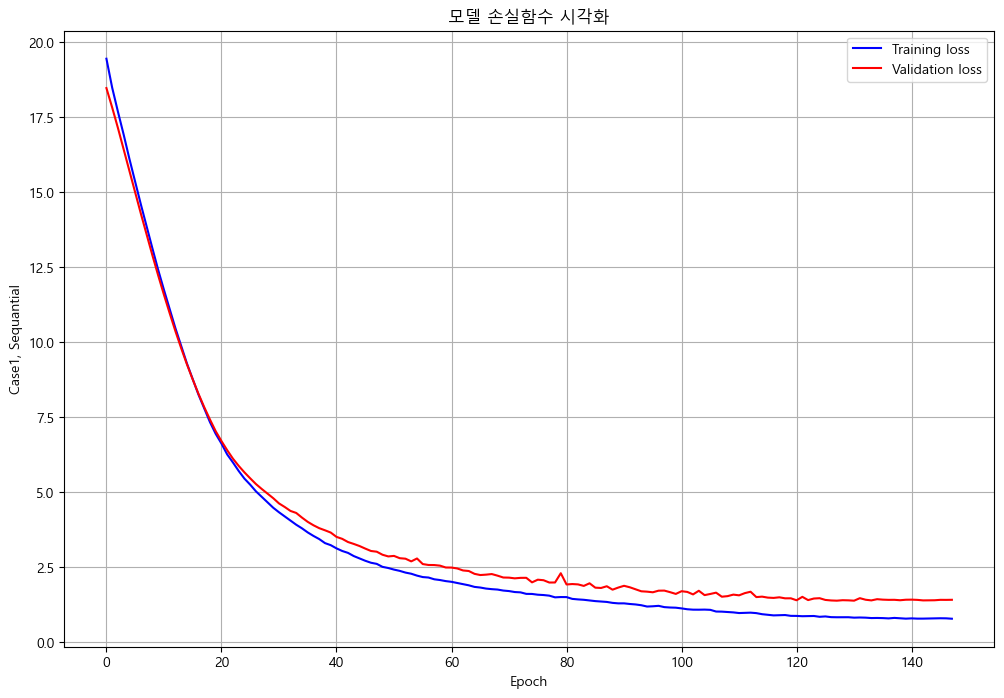

In [13]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
    
initial_lr = 0.0005

optimizer = Adam(learning_rate=initial_lr)
# optimizer = RMSprop(learning_rate=initial_lr, clipvalue=1.0)

# 학습률 재시작
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

case1_lstm_uni = Sequential()

case1_lstm_uni.add(LSTM(128, return_sequences=True,
                          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                          bias_regularizer=l1_l2(l1=0.005, l2=0.005),    
                          input_shape=x_train_multi.shape[-2:]))
case1_lstm_uni.add(BatchNormalization())
case1_lstm_uni.add(Dropout(0.3))

case1_lstm_uni.add(LSTM(64, return_sequences=True,
                          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                          bias_regularizer=l1_l2(l1=0.005, l2=0.005)))
case1_lstm_uni.add(BatchNormalization())
case1_lstm_uni.add(Dropout(0.3))

case1_lstm_uni.add(LSTM(32, activation='relu',
                          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                          bias_regularizer=l1_l2(l1=0.005, l2=0.005)))
case1_lstm_uni.add(BatchNormalization())
case1_lstm_uni.add(Dropout(0.3))

case1_lstm_uni.add(Dense(24, activation='relu'))
case1_lstm_uni.add(Dense(12))

case1_lstm_uni.compile(optimizer=optimizer, loss='mse')

case1_lstm_uni_history = case1_lstm_uni.fit(
    train_data_multi, 
    epochs = EPOCHS, 
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_data = val_data_multi, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    callbacks=[
        lr_restart, 
        early_stop
    ])

plot_train_history(case1_lstm_uni_history, "Case1, Sequantial")

In [34]:
Y_hat_case1_uni = case1_lstm_uni.predict(x_test_multi)

1/1 [==============================] - 0s 19ms/step


In [35]:
Y = y_test_multi * case1_std[-1] + case1_mean[-1]

In [36]:
Y_hat_case1_uni = Y_hat_case1_uni * case1_std[-1] + case1_mean[-1]

### 양방향 LSTM

Epoch 1/200
16/16 [==============================] - 6s 91ms/step - loss: 56.0350 - val_loss: 53.7315 - lr: 5.0000e-04
Epoch 2/200
16/16 [==============================] - 0s 18ms/step - loss: 52.7929 - val_loss: 50.7452 - lr: 5.0000e-04
Epoch 3/200
16/16 [==============================] - 0s 17ms/step - loss: 49.5779 - val_loss: 47.6246 - lr: 5.0000e-04
Epoch 4/200
16/16 [==============================] - 0s 17ms/step - loss: 46.2799 - val_loss: 44.4566 - lr: 5.0000e-04
Epoch 5/200
16/16 [==============================] - 0s 17ms/step - loss: 43.0487 - val_loss: 41.3019 - lr: 5.0000e-04
Epoch 6/200
16/16 [==============================] - 0s 18ms/step - loss: 39.8698 - val_loss: 38.2206 - lr: 5.0000e-04
Epoch 7/200
16/16 [==============================] - 0s 17ms/step - loss: 36.7910 - val_loss: 35.2448 - lr: 5.0000e-04
Epoch 8/200
16/16 [==============================] - 0s 18ms/step - loss: 33.7938 - val_loss: 32.3894 - lr: 5.0000e-04
Epoch 9/200
16/16 [=============================

16/16 [==============================] - 0s 18ms/step - loss: 2.5450 - val_loss: 2.9898 - lr: 5.0000e-04
Epoch 71/200
16/16 [==============================] - 0s 17ms/step - loss: 2.5400 - val_loss: 3.1299 - lr: 5.0000e-04
Epoch 72/200
16/16 [==============================] - 0s 17ms/step - loss: 2.4920 - val_loss: 2.9167 - lr: 5.0000e-04
Epoch 73/200
16/16 [==============================] - 0s 17ms/step - loss: 2.4275 - val_loss: 2.8957 - lr: 5.0000e-04
Epoch 74/200
16/16 [==============================] - 0s 17ms/step - loss: 2.4034 - val_loss: 2.8225 - lr: 5.0000e-04
Epoch 75/200
16/16 [==============================] - 0s 17ms/step - loss: 2.3649 - val_loss: 2.7721 - lr: 5.0000e-04
Epoch 76/200
16/16 [==============================] - 0s 19ms/step - loss: 2.3064 - val_loss: 2.7480 - lr: 5.0000e-04
Epoch 77/200
16/16 [==============================] - 0s 18ms/step - loss: 2.2649 - val_loss: 2.7078 - lr: 5.0000e-04
Epoch 78/200
16/16 [==============================] - 0s 17ms/step - 

Epoch 137/200
16/16 [==============================] - 0s 18ms/step - loss: 1.1974 - val_loss: 1.7252 - lr: 1.2500e-04
Epoch 138/200
16/16 [==============================] - 0s 17ms/step - loss: 1.2011 - val_loss: 1.7271 - lr: 1.2500e-04
Epoch 139/200
16/16 [==============================] - 0s 19ms/step - loss: 1.1933 - val_loss: 1.7471 - lr: 1.2500e-04
Epoch 140/200
13/16 [=======================>......] - ETA: 0s - loss: 1.1867
Epoch 140: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
16/16 [==============================] - 0s 17ms/step - loss: 1.1814 - val_loss: 1.7133 - lr: 1.2500e-04
Epoch 141/200
16/16 [==============================] - 0s 18ms/step - loss: 1.1630 - val_loss: 1.7055 - lr: 6.2500e-05
Epoch 142/200
16/16 [==============================] - 0s 18ms/step - loss: 1.1796 - val_loss: 1.7051 - lr: 6.2500e-05
Epoch 143/200
16/16 [==============================] - 0s 18ms/step - loss: 1.1774 - val_loss: 1.7099 - lr: 6.2500e-05
Epoch 144/200
16/16 [=====

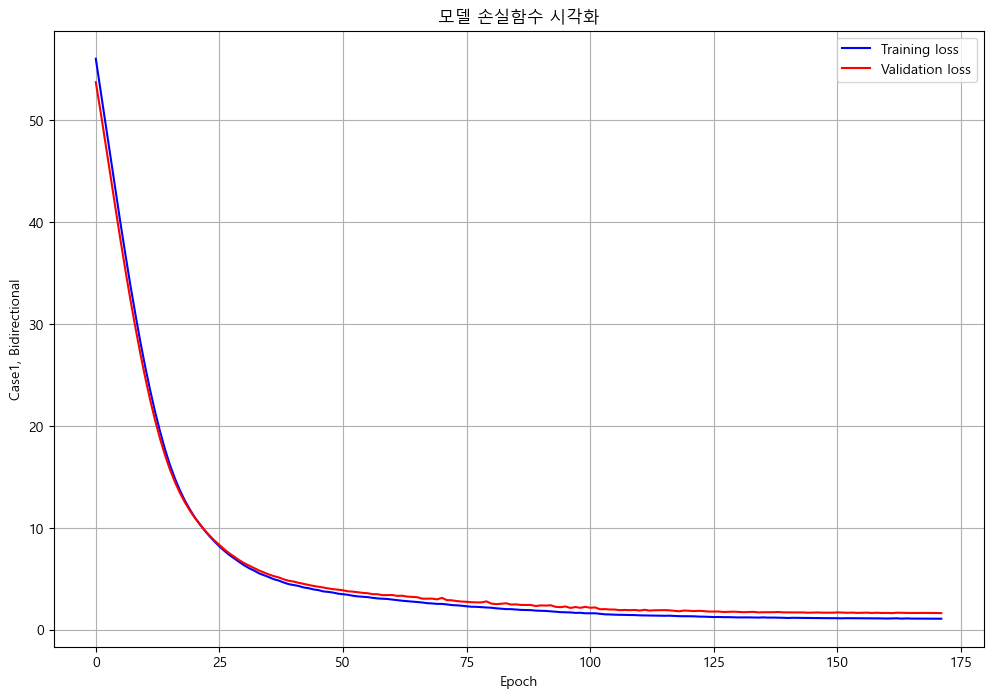

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Attention, Concatenate
from tensorflow.keras.regularizers import l1_l2

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import legacy as legacy_optimizers

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 학습률 재시작
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 정의
inputs = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))

x = Bidirectional(LSTM(128, return_sequences=True,
                       kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                       bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                       kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                       bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu',
          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
          bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
outputs = Dense(12)(x)

case1_lstm_bi = Model(inputs=inputs, outputs=outputs)

# 모델 빌드 및 컴파일
case1_lstm_bi.build(input_shape=(None, x_train_multi.shape[1], x_train_multi.shape[2]))
case1_lstm_bi.compile(optimizer=optimizer, loss='mse')

# 모델 학습
case1_lstm_bi_history = case1_lstm_bi.fit(
    train_data_multi,
    epochs=EPOCHS,
    steps_per_epoch=x_train_multi.shape[0] // BATCH_SIZE,
    validation_data=val_data_multi,
    validation_steps=x_val_multi.shape[0] // BATCH_SIZE,
    callbacks=[lr_restart, early_stop]
)

plot_train_history(case1_lstm_bi_history, "Case1, Bidirectional")

In [37]:
Y_hat_case1_bi = case1_lstm_bi.predict(x_test_multi)

1/1 [==============================] - 1s 945ms/step


In [38]:
Y_hat_case1_bi = Y_hat_case1_bi * case1_std[-1] + case1_mean[-1]

# Case2) WTIO, SETIO & SOI 로그변환

## 데이터 전처리

### 부호 유지 로그 변환

In [87]:
case2_df = data[['WTIO', 'SETIO', 'ONI', 'SOI', 'D20_SCTR']]
case2_dts = case2_df.values

case2_dts = np.sign(case2_dts) * np.log1p(np.abs(case2_dts))

### 데이터 분포 확인

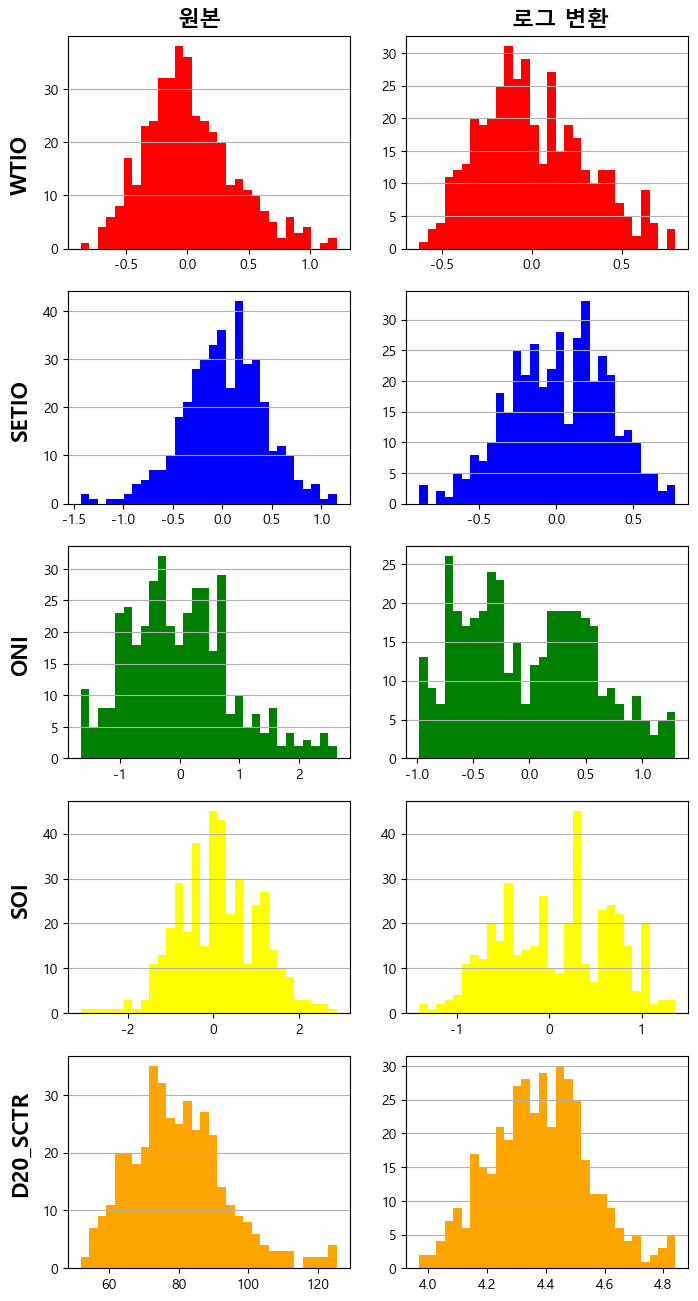

In [100]:
fig, ax = plt.subplots(5, 2, figsize=(8, 16))

i = 0

colors = ["red", "blue", "green", "yellow", "orange"]

for column in case2_df.columns:

    ax[i][0].hist(case2_df[column], bins=30, label=column, color=colors[i])
    ax[i][0].grid(axis = "y")
    
    ax[i][1].hist(case2_dts[:, i], bins=30, label=column, color=colors[i])
    ax[i][1].grid(axis = "y")

    i += 1
    
for j, col_title in enumerate(['원본', '로그 변환']):
    fig.text(0.29 + j * 0.45, 0.89, col_title, ha='center', va='center', fontsize=16, fontweight='bold')
    
for i, label in enumerate(['WTIO', 'SETIO', 'ONI', 'SOI', 'D20_SCTR']):
    fig.text(0.08, 0.8 - i * 0.153, label, va='center', ha='right', fontsize=16, rotation=90, fontweight='bold')

## 데이터 분리

In [101]:
# 학습 데이터
x_train_multi, y_train_multi = multivariate_data(case2_dts, case2_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# 검증 데이터
x_val_multi, y_val_multi = multivariate_data(case2_dts, case2_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# 테스트 데이터
x_test_multi, y_test_multi = multivariate_data(case2_dts, case2_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

print(f"학습 데이터 형태: {x_train_multi.shape}")
print(f"검증 데이터 형태: {x_val_multi.shape}")
print(f"테스트 데이터 형태: {x_test_multi.shape}")

print('과거 데이터 윈도우 형태: {}'.format(x_train_multi[0].shape))
print('예측 목표 기간 형태: {}'.format(y_train_multi[0].shape))

학습 데이터 형태: (256, 12, 5)
검증 데이터 형태: (56, 12, 5)
테스트 데이터 형태: (16, 12, 5)
과거 데이터 윈도우 형태: (12, 5)
예측 목표 기간 형태: (12,)


In [102]:
BUFFER_SIZE = 100

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))

train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

## 모델 학습

### 단방향 LSTM

Epoch 1/200
16/16 [==============================] - 5s 56ms/step - loss: 36.7250 - val_loss: 36.7463 - lr: 5.0000e-04
Epoch 2/200
16/16 [==============================] - 0s 13ms/step - loss: 34.0813 - val_loss: 35.9854 - lr: 5.0000e-04
Epoch 3/200
16/16 [==============================] - 0s 12ms/step - loss: 31.9947 - val_loss: 35.1797 - lr: 5.0000e-04
Epoch 4/200
16/16 [==============================] - 0s 12ms/step - loss: 30.1517 - val_loss: 34.1794 - lr: 5.0000e-04
Epoch 5/200
16/16 [==============================] - 0s 12ms/step - loss: 27.6768 - val_loss: 32.9016 - lr: 5.0000e-04
Epoch 6/200
16/16 [==============================] - 0s 12ms/step - loss: 25.5295 - val_loss: 31.3459 - lr: 5.0000e-04
Epoch 7/200
16/16 [==============================] - 0s 12ms/step - loss: 23.4361 - val_loss: 29.0623 - lr: 5.0000e-04
Epoch 8/200
16/16 [==============================] - 0s 13ms/step - loss: 21.3304 - val_loss: 26.8097 - lr: 5.0000e-04
Epoch 9/200
16/16 [=============================

16/16 [==============================] - 0s 13ms/step - loss: 3.3054 - val_loss: 2.8431 - lr: 5.0000e-04
Epoch 71/200
16/16 [==============================] - 0s 13ms/step - loss: 3.0096 - val_loss: 2.8046 - lr: 5.0000e-04
Epoch 72/200
16/16 [==============================] - 0s 13ms/step - loss: 3.0299 - val_loss: 2.8162 - lr: 5.0000e-04
Epoch 73/200
16/16 [==============================] - 0s 13ms/step - loss: 2.9628 - val_loss: 2.5863 - lr: 5.0000e-04
Epoch 74/200
16/16 [==============================] - 0s 13ms/step - loss: 2.8460 - val_loss: 2.5364 - lr: 5.0000e-04
Epoch 75/200
16/16 [==============================] - 0s 13ms/step - loss: 2.7383 - val_loss: 2.4948 - lr: 5.0000e-04
Epoch 76/200
16/16 [==============================] - 0s 12ms/step - loss: 2.7169 - val_loss: 2.4209 - lr: 5.0000e-04
Epoch 77/200
16/16 [==============================] - 0s 14ms/step - loss: 2.6527 - val_loss: 2.3708 - lr: 5.0000e-04
Epoch 78/200
16/16 [==============================] - 0s 14ms/step - 

16/16 [==============================] - 0s 12ms/step - loss: 1.0660 - val_loss: 0.8811 - lr: 5.0000e-04
Epoch 140/200
16/16 [==============================] - 0s 13ms/step - loss: 1.0699 - val_loss: 0.8346 - lr: 5.0000e-04
Epoch 141/200
16/16 [==============================] - 0s 13ms/step - loss: 1.0198 - val_loss: 0.7850 - lr: 5.0000e-04
Epoch 142/200
16/16 [==============================] - 0s 13ms/step - loss: 1.0920 - val_loss: 0.7685 - lr: 5.0000e-04
Epoch 143/200
16/16 [==============================] - 0s 12ms/step - loss: 1.0334 - val_loss: 0.7897 - lr: 5.0000e-04
Epoch 144/200
16/16 [==============================] - 0s 13ms/step - loss: 0.9957 - val_loss: 0.7279 - lr: 5.0000e-04
Epoch 145/200
16/16 [==============================] - 0s 12ms/step - loss: 1.0291 - val_loss: 0.7895 - lr: 5.0000e-04
Epoch 146/200
16/16 [==============================] - 0s 13ms/step - loss: 1.0339 - val_loss: 0.8099 - lr: 5.0000e-04
Epoch 147/200
16/16 [==============================] - 0s 13ms

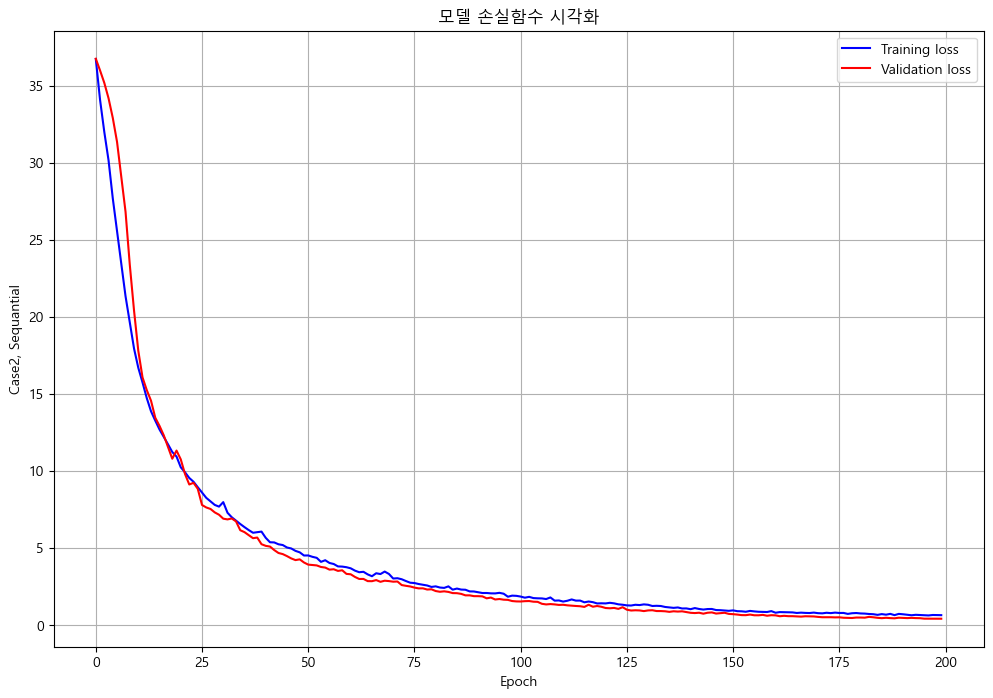

In [103]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
    
initial_lr = 0.0005

optimizer = Adam(learning_rate=initial_lr)
# optimizer = RMSprop(learning_rate=initial_lr, clipvalue=1.0)

# 학습률 재시작
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

case2_lstm_uni = Sequential()

case2_lstm_uni.add(LSTM(128, return_sequences=True,
                          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                          bias_regularizer=l1_l2(l1=0.005, l2=0.005),    
                          input_shape=x_train_multi.shape[-2:]))
case2_lstm_uni.add(BatchNormalization())
case2_lstm_uni.add(Dropout(0.3))

case2_lstm_uni.add(LSTM(64, return_sequences=True,
                          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                          bias_regularizer=l1_l2(l1=0.005, l2=0.005)))
case2_lstm_uni.add(BatchNormalization())
case2_lstm_uni.add(Dropout(0.3))

case2_lstm_uni.add(LSTM(32, activation='relu',
                          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                          bias_regularizer=l1_l2(l1=0.005, l2=0.005)))
case2_lstm_uni.add(BatchNormalization())
case2_lstm_uni.add(Dropout(0.3))

case2_lstm_uni.add(Dense(24, activation='relu'))
case2_lstm_uni.add(Dense(12))

case2_lstm_uni.compile(optimizer=optimizer, loss='mse')

case2_lstm_uni_history = case2_lstm_uni.fit(
    train_data_multi, 
    epochs = EPOCHS, 
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_data = val_data_multi, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    callbacks=[
        lr_restart, 
        early_stop
    ])

plot_train_history(case2_lstm_uni_history, "Case2, Sequantial")

In [106]:
Y_hat_case2_uni = case2_lstm_uni.predict(x_test_multi)

Y_hat_case2_uni = np.sign(Y_hat_case2_uni) * (np.expm1(np.abs(Y_hat_case2_uni)))

1/1 [==============================] - 1s 594ms/step


In [107]:
Y = np.sign(y_test_multi) * (np.expm1(np.abs(y_test_multi)))

### 양방향 LSTM

Epoch 1/200
16/16 [==============================] - 6s 88ms/step - loss: 77.0320 - val_loss: 73.3128 - lr: 5.0000e-04
Epoch 2/200
16/16 [==============================] - 0s 18ms/step - loss: 73.9780 - val_loss: 71.2537 - lr: 5.0000e-04
Epoch 3/200
16/16 [==============================] - 0s 18ms/step - loss: 70.7579 - val_loss: 68.8769 - lr: 5.0000e-04
Epoch 4/200
16/16 [==============================] - 0s 18ms/step - loss: 67.6515 - val_loss: 66.3103 - lr: 5.0000e-04
Epoch 5/200
16/16 [==============================] - 0s 19ms/step - loss: 64.4646 - val_loss: 63.6177 - lr: 5.0000e-04
Epoch 6/200
16/16 [==============================] - 0s 18ms/step - loss: 61.2784 - val_loss: 60.7420 - lr: 5.0000e-04
Epoch 7/200
16/16 [==============================] - 0s 18ms/step - loss: 57.9945 - val_loss: 57.8527 - lr: 5.0000e-04
Epoch 8/200
16/16 [==============================] - 0s 19ms/step - loss: 54.5821 - val_loss: 54.9301 - lr: 5.0000e-04
Epoch 9/200
16/16 [=============================

Epoch 70/200
16/16 [==============================] - 0s 19ms/step - loss: 4.7675 - val_loss: 4.5702 - lr: 5.0000e-04
Epoch 71/200
16/16 [==============================] - 0s 19ms/step - loss: 4.6685 - val_loss: 4.8656 - lr: 5.0000e-04
Epoch 72/200
16/16 [==============================] - 0s 18ms/step - loss: 4.5077 - val_loss: 4.3158 - lr: 5.0000e-04
Epoch 73/200
16/16 [==============================] - 0s 18ms/step - loss: 4.3042 - val_loss: 4.2042 - lr: 5.0000e-04
Epoch 74/200
16/16 [==============================] - 0s 18ms/step - loss: 4.1473 - val_loss: 4.1759 - lr: 5.0000e-04
Epoch 75/200
16/16 [==============================] - 0s 18ms/step - loss: 4.1158 - val_loss: 4.1241 - lr: 5.0000e-04
Epoch 76/200
16/16 [==============================] - 0s 22ms/step - loss: 3.9680 - val_loss: 3.7044 - lr: 5.0000e-04
Epoch 77/200
16/16 [==============================] - 0s 18ms/step - loss: 3.9131 - val_loss: 3.9323 - lr: 5.0000e-04
Epoch 78/200
16/16 [==============================] - 0s

16/16 [==============================] - 0s 18ms/step - loss: 1.6245 - val_loss: 1.3831 - lr: 5.0000e-04
Epoch 140/200
16/16 [==============================] - 0s 18ms/step - loss: 1.5912 - val_loss: 1.3878 - lr: 5.0000e-04
Epoch 141/200
16/16 [==============================] - 0s 20ms/step - loss: 1.5815 - val_loss: 1.3341 - lr: 5.0000e-04
Epoch 142/200
16/16 [==============================] - 0s 18ms/step - loss: 1.5333 - val_loss: 1.2940 - lr: 5.0000e-04
Epoch 143/200
16/16 [==============================] - 0s 18ms/step - loss: 1.5616 - val_loss: 1.3450 - lr: 5.0000e-04
Epoch 144/200
16/16 [==============================] - 0s 19ms/step - loss: 1.5415 - val_loss: 1.3091 - lr: 5.0000e-04
Epoch 145/200
16/16 [==============================] - 0s 20ms/step - loss: 1.5176 - val_loss: 1.2622 - lr: 5.0000e-04
Epoch 146/200
16/16 [==============================] - 0s 18ms/step - loss: 1.5693 - val_loss: 1.2482 - lr: 5.0000e-04
Epoch 147/200
16/16 [==============================] - 0s 19ms

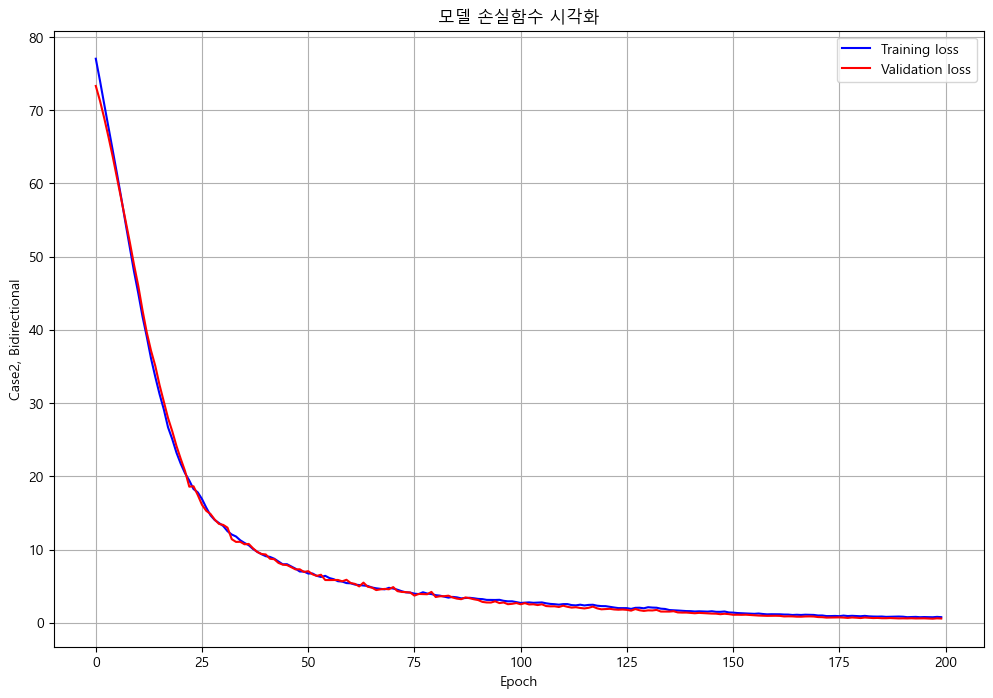

In [108]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Attention, Concatenate
from tensorflow.keras.regularizers import l1_l2

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import legacy as legacy_optimizers

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 학습률 재시작
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 정의
inputs = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))

x = Bidirectional(LSTM(128, return_sequences=True,
                       kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                       bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                       kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                       bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu',
          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
          bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
outputs = Dense(12)(x)

case2_lstm_bi = Model(inputs=inputs, outputs=outputs)

# 모델 빌드 및 컴파일
case2_lstm_bi.build(input_shape=(None, x_train_multi.shape[1], x_train_multi.shape[2]))
case2_lstm_bi.compile(optimizer=optimizer, loss='mse')

# 모델 학습
case2_lstm_bi_history = case2_lstm_bi.fit(
    train_data_multi,
    epochs=EPOCHS,
    steps_per_epoch=x_train_multi.shape[0] // BATCH_SIZE,
    validation_data=val_data_multi,
    validation_steps=x_val_multi.shape[0] // BATCH_SIZE,
    callbacks=[lr_restart, early_stop]
)

plot_train_history(case2_lstm_bi_history, "Case2, Bidirectional")

In [109]:
Y_hat_case2_bi = case2_lstm_bi.predict(x_test_multi)

Y_hat_case2_bi = np.sign(Y_hat_case2_bi) * (np.expm1(np.abs(Y_hat_case2_bi)))

1/1 [==============================] - 1s 974ms/step


# Case3) DMI & SOI 표준화

## 데이터 전처리

In [40]:
case3_df = data[['DMI', 'ONI', 'SOI', 'D20_SCTR']]

case3_dts = case3_df.values

case3_mean = case3_dts.mean(axis=0)
case3_std = case3_dts.std(axis=0)
case3_dts = (case3_dts-case3_mean)/case3_std

## 데이터 분리

In [57]:
# 학습 데이터
x_train_multi, y_train_multi = multivariate_data(case3_dts, case3_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# 검증 데이터
x_val_multi, y_val_multi = multivariate_data(case3_dts, case3_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# 테스트 데이터
x_test_multi, y_test_multi = multivariate_data(case3_dts, case3_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

print(f"학습 데이터 형태: {x_train_multi.shape}")
print(f"검증 데이터 형태: {x_val_multi.shape}")
print(f"테스트 데이터 형태: {x_test_multi.shape}")

print('과거 데이터 윈도우 형태: {}'.format(x_train_multi[0].shape))
print('예측 목표 기간 형태: {}'.format(y_train_multi[0].shape))

학습 데이터 형태: (256, 12, 4)
검증 데이터 형태: (56, 12, 4)
테스트 데이터 형태: (16, 12, 4)
과거 데이터 윈도우 형태: (12, 4)
예측 목표 기간 형태: (12,)


In [ ]:
BUFFER_SIZE = 100

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))

train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

## 모델 학습

### 단방향 LSTM

In [60]:
x_train_multi.shape[-2:]

(12, 4)

In [58]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
    
initial_lr = 0.0005

optimizer = Adam(learning_rate=initial_lr)
# optimizer = RMSprop(learning_rate=initial_lr, clipvalue=1.0)

# 학습률 재시작
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

case3_lstm_uni = Sequential()

case3_lstm_uni.add(LSTM(128, return_sequences=True,
                          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                          bias_regularizer=l1_l2(l1=0.005, l2=0.005),    
                          input_shape=x_train_multi.shape[-2:]))
case3_lstm_uni.add(BatchNormalization())
case3_lstm_uni.add(Dropout(0.3))

case3_lstm_uni.add(LSTM(64, return_sequences=True,
                          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                          bias_regularizer=l1_l2(l1=0.005, l2=0.005)))
case3_lstm_uni.add(BatchNormalization())
case3_lstm_uni.add(Dropout(0.3))

case3_lstm_uni.add(LSTM(32, activation='relu',
                          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                          bias_regularizer=l1_l2(l1=0.005, l2=0.005)))
case3_lstm_uni.add(BatchNormalization())
case3_lstm_uni.add(Dropout(0.3))

case3_lstm_uni.add(Dense(24, activation='relu'))
case3_lstm_uni.add(Dense(12))

case3_lstm_uni.compile(optimizer=optimizer, loss='mse')

case3_lstm_uni_history = case3_lstm_uni.fit(
    train_data_multi, 
    epochs = EPOCHS, 
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_data = val_data_multi, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    callbacks=[
        lr_restart, 
        early_stop
    ])

plot_train_history(case3_lstm_uni_history, "Case3, Sequantial")

Epoch 1/200


ValueError: in user code:

    File "C:\Users\5r2w1\anaconda3\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\5r2w1\anaconda3\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\5r2w1\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\5r2w1\anaconda3\lib\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\5r2w1\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\5r2w1\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 12, 4), found shape=(None, 12, 5)
